# Loading packages and colors

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%run weighted_kde_modified.ipynb
import seaborn as sns
from tqdm import tqdm
sns.set_style("white")
sns.set_context("paper")
from scipy.interpolate import interp1d
import statsmodels.api as sm
from scipy.stats import spearmanr,pearsonr


Defining colors

In [2]:
rescale_colors = lambda l: [i/255 for i in l]

In [3]:
blaa_moerk = rescale_colors([0,69,110])
blaa_moerk2 = rescale_colors([64,116,147])
blaa_moerk3 = rescale_colors([191,208,219])

blaa_lys = rescale_colors([127,162,183])
blaa_lys2 = rescale_colors([199,234,251])
blaa_lys3 = rescale_colors([212,239,252])
blaa_lys4 = rescale_colors([226,244,253])

graa_moerk = rescale_colors([83,83,83])
graa_moerk2 = rescale_colors([140,140,140])
graa_lys = rescale_colors([197,197,197])

roed = rescale_colors([160,33,37])
baggrund = rescale_colors([245,250,254])


# Estimation of densities

The data from IPUMS is weigthed samples. The weights have to enter into the estimation. This simplest way to incorporate this is to simply draw a sample with replacement with numpy, where samples are drawn according to their weights. I draw 100k samples from each year-by-gender distributions.

I remove observations with no income. The magnitude of the results is sensitive to this restriction. The qualitative results however remain unchanged.

I have estimated the densities in a previous nversion of this notebook.

In [4]:
import pickle
results_dict = pickle.load(open("output/distributions.pkl", "rb"))

In [5]:
#results_dict['cdf']

In [6]:
pdf_d = results_dict['pdf']
cdf_d = results_dict['cdf']
icdf_d = results_dict['icdf']
medians_d = results_dict['medians']
means_d = results_dict['means']


# Quantile ratios

In [7]:
year_list = [1970, 1980, 1990, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016]

In [9]:
eval_range = np.linspace(0.01,.99,200)
quantratio = pd.DataFrame()
for y in year_list:
    icdfs =  icdf_d[y]
    temp = pd.DataFrame(eval_range)
    temp.columns = ['p']
    temp['icdf_male'] = icdfs['Male'](eval_range)
    temp['icdf_female'] = icdfs['Female'](eval_range)
    temp['ratio'] = temp['icdf_male']/temp['icdf_female']
    temp['y'] = y
    quantratio = quantratio.append(temp)

In [10]:
year_list2 = [1970,1980,1990,2000,2004,2010,2016]
color = [graa_moerk,'gray',blaa_lys4,blaa_lys,blaa_moerk2,blaa_moerk,roed]
ls = ['-','-.','--','-','-.','--',':']

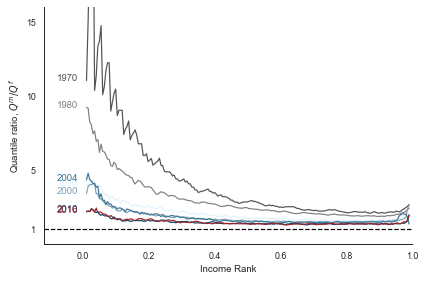

In [11]:
sns.set_context('paper')
#year_list2 = [1970,1980,1990,2000,2004,2010,2016]
#year_list2 = [2014]
#fig,ax = plt.subplots(figsize=(6,4))
fig,ax = plt.subplots()
for idx, y in enumerate(year_list2):
    temp = quantratio[quantratio['y']==y]
    ax.plot(temp['p'],temp['ratio'],label=str(y),color=color[idx],ls='-')
    ax.text(-.08,temp['ratio'].iloc[0],s=str(y),color=color[idx])
#ax.legend()  

ax.axhline(1,color='k',ls='--')

ax.set_ylim(0,16)
ax.set_xlim(-.12,1)
ax.set_xlabel('Income Rank')
ax.set_ylabel('Quantile ratio, $Q^m/Q^f$')
ax.set_yticks([1,5,10,15])
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
sns.despine()
fig.tight_layout()
fig.savefig('output/quantile_ratios.pdf',format='pdf',bbox_inches='tight')

# Likelihood ratios

In [12]:
eval_range2 = np.linspace(0.01,.9,200)

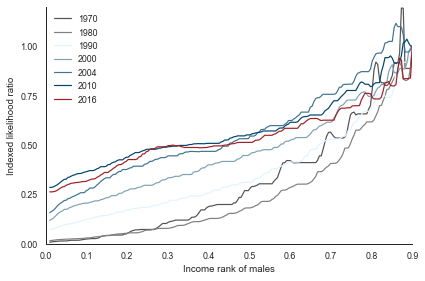

In [13]:
sns.set_context('paper')
#fig,ax = plt.subplots(figsize=(6,4))
fig,ax = plt.subplots()
for idx, y in enumerate(year_list2):
    icdfs =  icdf_d[y]
    pdfs =  pdf_d[y]
    inc_range = icdfs['Male'](eval_range2)
    LR = pdfs['Male'](inc_range)/pdfs['Female'](inc_range)
    LR_index = LR/LR[-1]
    ax.plot(eval_range2,LR_index,label=str(y),color=color[idx],ls='-')
ax.set_xlabel('Income rank of males')
ax.set_ylabel('Indexed likelihood ratio')
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(frameon=False)
ax.set_ylim(0,1.2)
ax.set_xlim(0,.9)
ax.set_yticks([0,.25,.5,.75,1])
sns.despine()
fig.tight_layout()
fig.savefig('output/likelihood_ratios.pdf',format='pdf',bbox_inches='tight',transparent=True)

# Analytical weights evaluated at mean

In [14]:
def lambdas(v,y,g='Male'):
    if g=='Male':
        return pdf_d[y]['Female'](icdf_d[y]['Male'](v)) /pdf_d[y]['Male'](icdf_d[y]['Male'](v))
    
    if g=='Female':
        return pdf_d[y]['Male'](icdf_d[y]['Female'](v)) /pdf_d[y]['Female'](icdf_d[y]['Female'](v))
    
    

def weight_ana_func(y,inc_eval='mean'):
    if inc_eval=='mean':
        inc = means_d[y]['all']
    if inc_eval=='median':
        inc = medians_d[y]['all']
    v_m = cdf_d[y]['Male'](inc)
    v_f = cdf_d[y]['Female'](inc)
    omega = pdf_d[y]['Male'](inc)/(pdf_d[y]['Male'](inc)+pdf_d[y]['Female'](inc))
    lm_f = lambdas(v_f,y,g='Male')
    lf_m = lambdas(v_m,y,g='Female')
    A = 3/4+1/4*(omega*lf_m+(1-omega)*lm_f)
    return A
    

In [15]:
adj_all = pd.DataFrame()
for y in year_list:
    temp = pd.DataFrame([y,weight_ana_func(y,inc_eval='mean'),weight_ana_func(y,inc_eval='median')]).T
    adj_all = adj_all.append(temp)
adj_all.columns = ['y','A_mean','A_median']

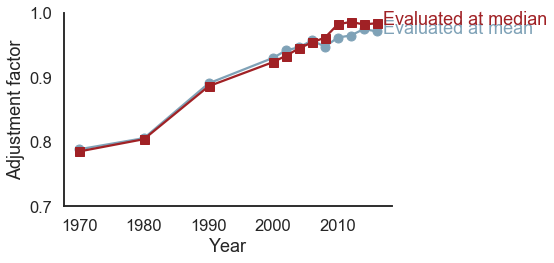

In [16]:
sns.set_context('talk')
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(adj_all['y'],adj_all['A_mean'],color=blaa_lys,marker='o',label='Evaluated at mean')
ax.plot(adj_all['y'],adj_all['A_median'],color=roed,marker='s',label='Evaluated at median')
ax.text(2017,adj_all['A_mean'].iloc[-1]-.0025,'Evaluated at mean',color=blaa_lys)
ax.text(2017,adj_all['A_median'].iloc[-1]-.0025,'Evaluated at median',color=roed)
#ax.legend(loc=4)
ax.set_xlabel('Year')
ax.set_ylabel('Adjustment factor')
ax.set_ylim(.7,1)
ax.set_yticks([.7,.8,.9,1])
#ax.set_xlim(1968,2018)
sns.despine()
fig.tight_layout()
fig.savefig('output/weights_ana.pdf',format='pdf',bbox_inches='tight',transparent=True)

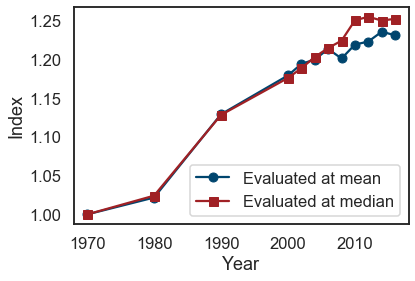

In [17]:
fig,ax = plt.subplots(figsize=(6,4))
ax.plot(adj_all['y'],adj_all['A_mean']/adj_all.loc[adj_all['y']==1970,'A_mean'],color=blaa_moerk,marker='o',label='Evaluated at mean')
ax.plot(adj_all['y'],adj_all['A_median']/adj_all.loc[adj_all['y']==1970,'A_median'],color=roed,marker='s',label='Evaluated at median')
ax.legend(loc=4)
ax.set_xlabel('Year')
ax.set_ylabel('Index')
#ax.set_ylim(.75,1)
ax.set_xlim(1968,2018)
fig.savefig('output/weights_ana_index.pdf',format='pdf',bbox_inches='tight')

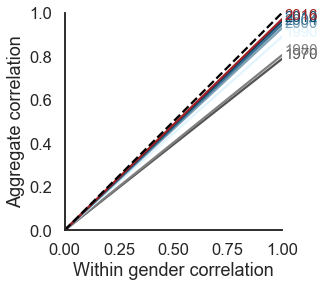

In [18]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(4,4))
u_range = np.linspace(0,1,200)
for idx, y in enumerate(year_list2):
    ax.plot(u_range,adj_all.loc[adj_all['y']==y,'A_mean'][0]*u_range,label=str(y),color=color[idx],ls='-')
    ax.text(1.01,(adj_all.loc[adj_all['y']==y,'A_mean'][0]*u_range)[-1],str(y),fontsize=15,color=color[idx])
ax.plot(u_range,u_range,ls='--',color='k')
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.legend(frameon=False)
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.set_aspect('equal')
ax.set_xlabel('Within gender correlation')
ax.set_ylabel('Aggregate correlation')
sns.despine()
fig.savefig('output/weights_ana_rank_corr.pdf',format='pdf',bbox_inches='tight',transparent=True)

### Weights

In [19]:
def weight_ana_inc(y,inc):
    v_m = cdf_d[y]['Male'](inc)
    v_f = cdf_d[y]['Female'](inc)
    omega = pdf_d[y]['Male'](inc)/(pdf_d[y]['Male'](inc)+pdf_d[y]['Female'](inc))
    lm_f = lambdas(v_f,y,g='Male')
    lf_m = lambdas(v_m,y,g='Female')
    A = 3/4+1/4*(omega*lf_m+(1-omega)*lm_f)
    return A

In [20]:
y=1980
v_range=np.linspace(0,.99,100)
inc_range = [icdf_d[y]['Male'](r) for r in v_range]
vf_list = [cdf_d[y]['Female'](i) for i in inc_range]
vm_list = [cdf_d[y]['Male'](i) for i in inc_range]
lm_f = [lambdas(v,y,g='Male') for v in vf_list]
lf_m = [lambdas(v,y,g='Female') for v in vm_list]
om_list = [pdf_d[y]['Male'](i)/(pdf_d[y]['Female'](i)+pdf_d[y]['Male'](i)) for i in inc_range]
om_m_list = [1-pdf_d[y]['Male'](i)/(pdf_d[y]['Female'](i)+pdf_d[y]['Male'](i)) for i in inc_range]
adj = [3/4+1/4*(om_list[i]*lm_f[i]+(1-om_list[i])*lf_m[i]) for i,_ in enumerate(inc_range)]

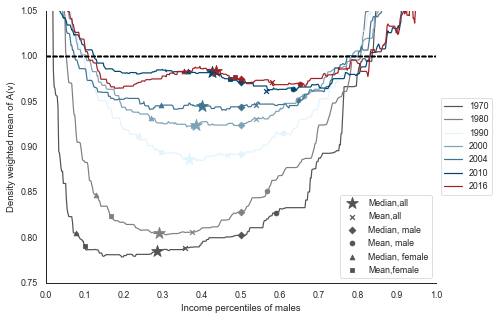

In [21]:
sns.set_context('paper')
fig,ax = plt.subplots(figsize=(7,5))

v_range=np.linspace(0.01,.99,500)
for idx, y in enumerate(year_list2):

    inc_range = [icdf_d[y]['Male'](r) for r in v_range]
    #vf_list = [cdf_d[y]['Female'](i) for i in inc_range]
    #vm_list = [cdf_d[y]['Male'](i) for i in inc_range]
    #lm_f = [lambdas(v,y,g='Male') for v in vf_list]
    #lf_m = [lambdas(v,y,g='Female') for v in vm_list]
    #om_list = [pdf_d[y]['Male'](i)/(pdf_d[y]['Female'](i)+pdf_d[y]['Male'](i)) for i in inc_range]
    #om_m_list = [1-pdf_d[y]['Male'](i)/(pdf_d[y]['Female'](i)+pdf_d[y]['Male'](i)) for i in inc_range]
    #adj = [3/4+1/4*(om_list[i]*lm_f[i]+(1-om_list[i])*lf_m[i]) for i,_ in enumerate(inc_range)]
    adj = [weight_ana_inc(y,inc) for inc in inc_range]
    ax.plot(v_range,adj,label=str(y),color=color[idx])
    
    mean_a = means_d[y]['all']
    median_a = medians_d[y]['all']
    median_am = medians_d[y]['Male']
    median_af = medians_d[y]['Female']
    
    mean_m = means_d[y]['Male']
    mean_f = means_d[y]['Female']
    if y==year_list2[0]:
        lm = ax.scatter(float(cdf_d[y]['Male'](mean_a)),weight_ana_inc(y,mean_a),marker='x',color=color[idx])
        lme = ax.scatter(float(cdf_d[y]['Male'](median_a)),weight_ana_inc(y,median_a),marker='*',color=color[idx],s=150)
        lmem = ax.scatter(.5,weight_ana_inc(y,icdf_d[y]['Male'](.5)),marker='D',color=color[idx])
        lmef = ax.scatter(float(cdf_d[y]['Male'](median_af)),weight_ana_inc(y,median_af),marker='^',color=color[idx])
        lmm= ax.scatter(float(cdf_d[y]['Male'](mean_m)),weight_ana_inc(y,mean_m),marker='o',color=color[idx])
        lmf = ax.scatter(float(cdf_d[y]['Male'](mean_f)),weight_ana_inc(y,mean_f),marker='s',color=color[idx])
    else:
        ax.scatter(float(cdf_d[y]['Male'](mean_a)),weight_ana_inc(y,mean_a),marker='x',color=color[idx])
        ax.scatter(float(cdf_d[y]['Male'](median_a)),weight_ana_inc(y,median_a),marker='*',color=color[idx],s=150)
        ax.scatter(.5,weight_ana_inc(y,icdf_d[y]['Male'](.5)),marker='D',color=color[idx])
        ax.scatter(float(cdf_d[y]['Male'](median_af)),weight_ana_inc(y,median_af),marker='^',color=color[idx])
        ax.scatter(float(cdf_d[y]['Male'](mean_m)),weight_ana_inc(y,mean_m),marker='o',color=color[idx])
        ax.scatter(float(cdf_d[y]['Male'](mean_f)),weight_ana_inc(y,mean_f),marker='s',color=color[idx])
    
    ax.axhline(1,ls='--',color='k')
ax.set_xticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
ax.set_ylim(.75-0.0001,1.05)
ax.set_xlim(0,1)
ax.set_xlabel('Income percentiles of males')
ax.set_ylabel('Density weighted mean of A(v)')

legend1 = plt.legend([lme,lm,lmem,lmm,lmef,lmf], [ "Median,all", "Mean,all", "Median, male","Mean, male", "Median, female","Mean,female"], loc=4)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().add_artist(legend1)
sns.despine()
fig.savefig('output/weights_evaluation_points.pdf',format='pdf',bbox_inches='tight',transparent=True)

# Copula-simulations

Define function to draw ranks from a Gaussian copula

In [22]:
def Gaussian_ranks(n=2000,rho=0.2,spear=True):
    import numpy as np
    from scipy.stats import norm
    """
    Function to create vectors of rank with known rank correlation (Spearman's rho)
        --- Input 
            n: Number of observations desired, default is 2000
            rho: Correlation coefficient. If Spear==False then this parameter enters directly into the covariance matrix, R.
            spear: If True then rho is interpreted as a Spearman rank and rescaled to fit the Gaussian copula.
        --- Output:
            Two uniformly distributed vectors with desired Spearman's rho.        
    """
    
    if spear:
        rho_G = 2*np.sin(rho*np.pi/6)
    else: 
        rho_G = rho
    
    R = np.array([[1,rho_G],
                [rho_G,1]])
    
    C = norm.cdf(np.random.multivariate_normal([0,0],R,size=n))
    U,V = C[:,0],C[:,1]
    
    return U,V



Define input for simulation

In [23]:
N = 10000
R = 100
rho_list = np.linspace(0,.99,100)
year_list3 = [1970,1980,1990,2000,2004,2010,2016]

In [24]:
sim_results = pd.DataFrame()
for y in tqdm(year_list3):
    icdfs = icdf_d[y]
    for rho in rho_list:
        temp = []
        moment3 = []
        moment4 = []
        for rep in range(R):
    
            U,V=Gaussian_ranks(n=N,rho=rho,spear=True)
            S = np.random.choice([True, False],N)

            X = U
            Y = S*icdfs['Male'](V)+(1-S)*icdfs['Female'](V)
            temp = temp+[spearmanr(X,Y)[0]]
            moment3 = moment3 + [np.mean((U-np.mean(U))*(V-np.mean(V))**2)] 
            moment4 = moment4 + [np.mean((U-np.mean(U))*(V-np.mean(V))**4)] 
        entry = pd.DataFrame([y,rho,np.mean(temp),np.mean(moment3),np.mean(moment4)]).T
        sim_results = sim_results.append(entry)
sim_results.columns = ['y','rho_within','rho_estimate','third_moment','fourth_moment']  

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [10:33<00:00, 88.34s/it]


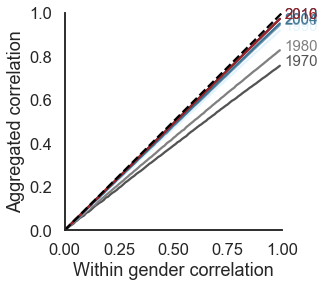

In [25]:
sns.set_context("talk")
fig,ax = plt.subplots(figsize=(4,4))
for idx,y in enumerate(year_list3):
    temp = sim_results[sim_results['y']==y]
    ax.plot(temp['rho_within'],temp['rho_estimate'],label=str(y),color=color[idx],ls='-')
    ax.text(1.01,temp['rho_estimate'].iloc[-1],str(y),fontsize=15,color=color[idx])
ax.set_xlabel('Within gender correlation')
ax.set_ylabel('Aggregated correlation')
ax.set_aspect('equal')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

xlim = ax.get_xlim()
line45 = np.linspace(xlim[0],xlim[1],10)
ax.plot(line45,line45,color='k',ls='--')
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.legend(frameon=False)
sns.despine()
fig.savefig('output/copula_simul.pdf',format='pdf',bbox_inches='tight',transparent=True)

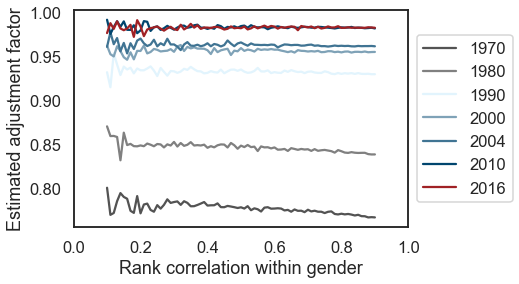

In [26]:
rho_min = .1
rho_max = .9
fig,ax = plt.subplots()
for idx,y in enumerate(year_list3):
    temp = sim_results[(sim_results['y']==y) & (sim_results['rho_within'].between(rho_min,rho_max))]
    ax.plot(temp['rho_within'],temp['rho_estimate']/temp['rho_within'],label=str(y),color=color[idx],ls='-')

ax.set_xlabel('Rank correlation within gender')
ax.set_ylabel('Estimated adjustment factor')
#ax.set_aspect('equal')
ax.set_xlim(0,1)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig('output/copula_simul_ratio.pdf',format='pdf',bbox_inches='tight')

# Comparison of simulated weights and analytical weights

In [27]:
weights_compare = pd.DataFrame()
for idx,y in enumerate(year_list3):
    temp = sim_results[(sim_results['y']==y) & (sim_results['rho_within'].between(rho_min,rho_max))]
    simul = np.mean(temp['rho_estimate']/temp['rho_within'])
    ana_mean = adj_all[adj_all['y']==y]['A_mean']
    ana_median = adj_all[adj_all['y']==y]['A_median']
    
    entry = pd.DataFrame([y,simul,ana_mean,ana_median]).T
    weights_compare = weights_compare.append(entry)
weights_compare.columns = ['y','w_simul','w_ana_mean','w_ana_median']

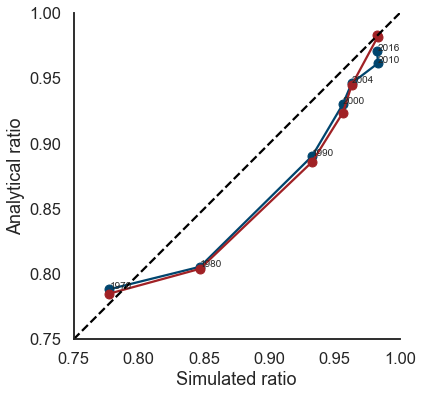

In [28]:
fig,ax = plt.subplots(figsize=(6,6))
ax.plot(weights_compare['w_simul'],weights_compare['w_ana_mean'],color=blaa_moerk,marker='o')
ax.plot(weights_compare['w_simul'],weights_compare['w_ana_median'],color=roed,marker='o')
ax.set_aspect('equal')

for idx,row in weights_compare.iterrows():
    ax.text(row['w_simul'],row['w_ana_mean'],row['y'],fontsize=10)

xmin,xmax = 0.75,1
ax.set_xlim(xmin,xmax)
ax.set_ylim(xmin,xmax)
line45 = np.linspace(xmin,xmax,4)
ax.set_ylabel('Analytical ratio')
ax.set_xlabel('Simulated ratio')
ax.plot(line45,line45,c='k',ls='--')
sns.despine()
fig.savefig('output/copula_simul_scatter.pdf',format='pdf',bbox_inches='tight')

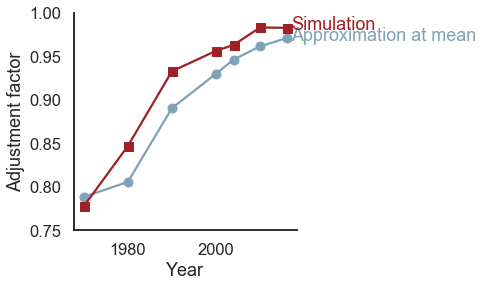

In [29]:
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(weights_compare['y'],weights_compare['w_ana_mean'],color=blaa_lys,marker='o',label='Evaluation at mean')
ax.plot(weights_compare['y'],weights_compare['w_simul'],color=roed,marker='s',label='Simulation')
ax.text(2017,weights_compare['w_ana_mean'].iloc[-1]-.0025,'Approximation at mean',color=blaa_lys)
ax.text(2017,weights_compare['w_simul'].iloc[-1]-.0025,'Simulation',color=roed)

ax.set_ylim(.75,1)
#ax.legend(loc=4)
ax.set_xlabel('Year')
ax.set_ylabel('Adjustment factor')
sns.despine()
fig.savefig('output/copula_simul_weights.pdf',format='pdf',bbox_inches='tight',transparent=True)

# Assortative machting


In [35]:
def draw_ass(rho,θ,y,N=2000):
    icdfs = icdf_d[y]
    U,V=Gaussian_ranks(n=N,rho=rho,spear=True)
    S = np.random.choice([True, False],N)

    Y = S*icdfs['Male'](V)+(1-S)*icdfs['Female'](V)

    df_m = pd.DataFrame([U[S==True],Y[S==True],V[S==True]],index=['Um','Ym','Vm']).T.sort_values('Vm')
    df_f = pd.DataFrame([U[S==False],Y[S==False],V[S==False]],index=['Uf','Yf','Vf']).T.iloc[0:df_m.shape[0]]

    df_f['random'] = np.random.uniform(0,1,df_f.shape[0])
    df_f['sort_key'] = θ*df_f['Vf']+(1-θ)*df_f['random']
    df_f = df_f.sort_values('sort_key')
    df_m['hh'] = df_m['Ym']+df_f['Yf']
    df_m = df_m.dropna(subset=['Um','hh'])

    sp = spearmanr(df_m['Um'],df_m['hh'])[0]
    return sp

In [36]:
def draw_ass2(rho,θ,icdfs,N=2000):
    
    U,V = Gaussian_ranks(n=N,rho=rho,spear=True)
    S = np.random.choice([True, False],N)
    nn = min([S.sum(),N-S.sum()])
    
    Um = U[S][:nn]
    Vm = V[S][:nn]
        
    m_argsort = Vm.argsort()
    Um = Um[m_argsort]
    Vm = Vm[m_argsort]
    
    rand = np.random.uniform(0,1,nn)
    
    Vf = V[S==False][:nn]
    sortkey = θ*Vf+(1-θ)*rand
    f_argsort = sortkey.argsort()
    Yhh = icdfs['Male'](Vm)+icdfs['Female'](Vf[f_argsort])
    
    
    Uf = U[S==False][:nn][f_argsort]
    
    U_all = np.concatenate([Um,Uf])
    Yhh2 = np.concatenate([Yhh,Yhh])
    Yhh2r = pd.Series(Yhh2).rank(pct=True).values
    U_allr = pd.Series(U_all).rank(pct=True).values
    
    sp_m = spearmanr(Um,Yhh)[0]
    sp_f = spearmanr(Uf,Yhh)[0]
    sp_all = spearmanr(U_all,Yhh2)[0]
    
    #Global ranks
    sp_m_gr = pearsonr(U_allr[:nn],Yhh2r[:nn])[0]
    sp_f_gr = pearsonr(U_allr[nn:],Yhh2r[nn:])[0]
    
    return sp_m, sp_f, sp_all, sp_m_gr , sp_f_gr

In [37]:
N = 4000
R = 10
rho_list = np.linspace(0,.99,20)
year_list3 = [1970,1980,1990,2000,2004,2010,2016]
ass_list = [0,.2,.4,.6,.8,1]

In [39]:
sim_results = pd.DataFrame()
for y in tqdm(year_list3):
    icdfs = icdf_d[y]
    for θ in ass_list:
        for rho in rho_list:
            temp_m = []
            temp_f = []
            temp_all = []
            temp_m_gr = []
            temp_f_gr = []
            for rep in range(R):
                c = draw_ass2(rho,θ,icdfs,N=N)
                temp_m += [c[0]]
                temp_f += [c[1]]
                temp_all += [c[2]]
                temp_m_gr += [c[3]]
                temp_f_gr += [c[4]]
            entry = pd.DataFrame([θ,y,rho,np.mean(temp_m),np.mean(temp_f),np.mean(temp_all),np.mean(temp_m_gr),np.mean(temp_f_gr)]).T
            sim_results = sim_results.append(entry)
sim_results.columns = ['ass','y','rho_within','rho_estimate_m','rho_estimate_f',
                       'rho_estimate_all','rho_estimate_m_gr','rho_estimate_f_gr']  


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:07<00:00,  9.63s/it]


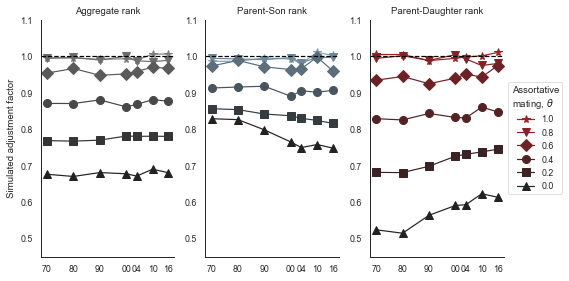

In [40]:
sns.set_context('paper')
sns.set_style("white")
fig,axes = plt.subplots(1,3,figsize=(8,4),sharey=False,sharex=False)
cmaps = [sns.dark_palette('Gray'),sns.dark_palette(blaa_lys),sns.dark_palette(roed)]
         
titles = ['Aggregate rank','Parent-Son rank','Parent-Daughter rank']
for j,a in enumerate(['_all','_m_gr','_f_gr']): #,'_m_gr','_f_gr']):
    #ax = axes[j//3,j%3]
    ax = axes[j]
    if j==0:
        ax.set_ylabel('Simulated adjustment factor')
        
    rho_within=rho_list[2]
    lc = len(ass_list)
    cmap = sns.dark_palette(blaa_lys)
    marker_list = [l for l in reversed(['^','s','o','D','v','*'])]
    for i,ass in enumerate(reversed(ass_list)):
        temp = sim_results[(sim_results['ass']==ass) & (sim_results['rho_within']!=0)].copy()
        temp['ratio'] = temp['rho_estimate'+a]/temp['rho_within']

        temp2 = temp.groupby('y')['ratio'].mean().reset_index()
        ax.plot(temp2['y'],temp2['ratio'],label='%.1f'%ass,color=cmaps[j][-i-1],marker=marker_list[i],markersize=8)

        #ax.plot(temp['y'],temp['rho_estimate'],label='%.1f'%ass)
    
    ax.set_xticks(year_list3)
    ax.set_xticklabels([str(s)[-2:] for s in year_list3])
    ax.axhline(1,ls='--',c='k')
    ax.set_title(titles[j])
    ax.set_ylim(.45,1.1)
    sns.despine(ax=ax)

ax.legend(loc='center left',title='Assortative\nmating, '+r'$\theta$', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
    
fig.savefig('output/copula_simul_assort_combined.pdf',format='pdf',bbox_inches='tight')